## Implementación

Vamos a implementar kmeans directamente con la librería scikitlearn.

In [25]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

Este dataset contiene datos sobre flores de iris, con 4 variables, así como la clase a la que pertenecen (3 clases en total).

In [8]:
iris = load_iris()
iris_df = pd.DataFrame(data= iris.data, columns= iris.feature_names)

iris_df['original_label'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),original_label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Ahora creamos nuestro modelo de clustering. Como sabemos de antemano que hay 3 clases, tomamos k=3.

In [20]:
kmeans = KMeans(n_clusters=3, max_iter=300, random_state=1)
kmeans.fit(iris.data)
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


Comparamos nuestros resultados con las variedades reales de iris:

In [21]:
iris_df["cluster"] = kmeans.labels_
iris_df.groupby(['original_label','cluster']).agg({'sepal length (cm)': 'count'})

sepal length (cm)
original_label cluster                   
0              1                       50
1              0                       47
               2                        3
2              0                       14
               2                       36

Vemos que la clase 0 la ha agrupado correctamente en un único clúster, pero las dos restantes están divididas entre dos. Es decir, nuestro modelo no es muy bueno. Veamos cómo mejorarlo.

## Preprocesado

Este algoritmo mide distancias, y como tal debe tenerse en cuenta:

1. Escalas: Los atributos pueden tener escalas muy distintas. Por eso es importante normalizar los datos.
2. Atributos categóricos: Para medir distancia entre atributos categóricos necesitamos transformarlos a numéricos, para poder usar las fórmulas de distancia.
3. Importancia de los atributos: Si un atributo es más importante que otro, se puede ponderar la distancia de cada atributo modificando la fórmula de distancia o bien el rango de valores del atributo.

In [22]:
from sklearn import preprocessing

cols = iris_df.columns[:-2]  # Exclude 'target' and 'cluster' columns

iris_df_norm = iris_df[cols].copy()
iris_df_norm[cols] = preprocessing.normalize(iris_df[cols])
iris_df_norm["original_label"] = iris_df["original_label"]
iris_df_norm.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),original_label
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.751400,0.405174,0.454784,0.141071,1.000000
std,0.044368,0.105624,0.159986,0.077977,0.819232
min,0.653877,0.238392,0.167836,0.014727,0.000000
25%,0.715261,0.326738,0.250925,0.048734,0.000000
50%,0.754883,0.354371,0.536367,0.164148,1.000000
75%,0.786912,0.527627,0.580025,0.197532,2.000000
max,0.860939,0.607125,0.636981,0.280419,2.000000


In [23]:
kmeans_norm = KMeans(n_clusters=3, max_iter=300, random_state=1)
kmeans_norm.fit(iris_df_norm[cols])

iris_df_norm["cluster"] = kmeans_norm.labels_
iris_df_norm.groupby(['original_label','cluster']).agg({'sepal length (cm)': 'count'})

sepal length (cm)
original_label cluster                   
0              1                       50
1              0                       45
               2                        5
2              2                       50

Vemos que mejora mucho y ya la clase 2 está también completamente asignada a un único clúster.

Puedes probar otras técnicas de escalado, como from StandardScaler. Compara los resultados de ambos preprocesados.

## Hiperparámetros

Hemos visto que el único hiperparámetro de k-means es el número de clústers k, pero también hemos visto animaciones que mostraban que el algoritmo es muy sensible a este valor.

¿Cómo elegir k?

Vamos a encontrar el mejor valor de k mediante el elbow method.

### Elbow method

El elbow method es una técnia heurística utilizada para determinar el número óptimo de clústers k. Consiste en representar la distancia cuadrática dentro de cada clúster en función del número de clústers e identificar el punto "codo" del gráfico, a partir del cual el descenso de la distancia cuadrática dentro de los clústers se hace más lento. Esto indica que añadir nuevos clústers no mejor el coste.

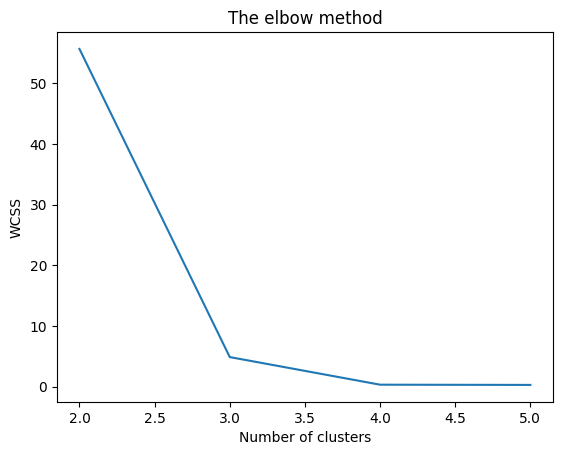

In [26]:
K = range(2, 6)
wcss = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(iris_df_norm)
    
    # append the model to fits
    wcss.append(model.inertia_)
    
plt.plot(range(2, 6), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Comprobamos efectivamente que el número de clústers óptimo es 3.

## Métrica

El objetivo no es sólo hacer clusters, sino hacer clusters buenos y significativos. Esto es epecialmente importante si no tenemos un ground truth con el que comparar. Un cluster de calidad es cuando los puntos de datos dentro de un cluster están cerca entre sí y lejos de otros clusters.

Existen diferentes métricas para evaluar los clústers, y una de las más comunes es silhouette.

### Coeficiente silhouette

Dada una instancia x, su coeficiente silhouette es la cantidad

s = b−a/max(a,b),

donde

- a es la distancia media entre x y todos los puntos de su mismo clúster y
- b es la distancia media ente x y todos los puntos en el clúster más cercano.

El coeficiente silhouette para un conjunto de puntos es la media del coeficiente silhouette de todos ellos.

- El mejor valor es 1, y el peor −1.
- Valores entorno a 0 indican clústers que se solapan.
Calculemos los coeficientes de los modelos que calculamos anteriormente.

In [27]:
from sklearn import metrics

metrics.silhouette_score(iris_df[cols], kmeans.labels_, metric='euclidean')

0.551191604619592

In [28]:
metrics.silhouette_score(iris_df_norm[cols], kmeans_norm.labels_, metric='euclidean')

0.5763264768222822

Vemos que, efectivamente, la normalización mejora el coeficiente de silhouette.